In [1]:
#checking GPU

import tensorflow as tf
print(tf.test.gpu_device_name())


/device:GPU:0


In [2]:
import pandas as pd
import os
import time
import numpy as np
import matplotlib.pyplot as plt
import keras
import tensorflow as tf
import seaborn as sns
from keras.models import Model
from keras.layers import Input, Dense
from sklearn.preprocessing import MinMaxScaler, Normalizer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score
from keras import backend as K
from keras import layers, losses
import itertools
import scipy
from scipy import io

#setting seaborn style
sns.set(style='whitegrid', context='notebook')

random_seed=4


Using TensorFlow backend.


In [3]:
# loading the mat file

# ********** loading 802.11ac file *****************
wifi_data_ac_16=scipy.io.loadmat('80211ac_5packets_16qam.mat')['waveStruct']['waveform'][0][0]
wifi_data_ac_16=wifi_data_ac_16.T
wifi_data_ac_16=wifi_data_ac_16.flatten()

wifi_data_ac_64=scipy.io.loadmat('80211ac_5packets.mat')['waveStruct']['waveform'][0][0]
wifi_data_ac_64=wifi_data_ac_64.T
wifi_data_ac_64=wifi_data_ac_64.flatten()

wifi_data_ac_256=scipy.io.loadmat('80211ac_5packets_256qam.mat')['waveStruct']['waveform'][0][0]
wifi_data_ac_256=wifi_data_ac_256.T
wifi_data_ac_256=wifi_data_ac_256.flatten()

# ************ loading 802.11ax file **************

wifi_data_ax_16=scipy.io.loadmat('80211ax_10packets_16qam.mat')['waveStruct']['waveform'][0][0]
wifi_data_ax_16=wifi_data_ax_16.T
wifi_data_ax_16=wifi_data_ax_16.flatten()

wifi_data_ax_64=scipy.io.loadmat('80211ax_10packets.mat')['waveStruct']['waveform'][0][0]
wifi_data_ax_64=wifi_data_ax_64.T
wifi_data_ax_64=wifi_data_ax_64.flatten()

wifi_data_ax_256=scipy.io.loadmat('80211ax_10packets_256qam.mat')['waveStruct']['waveform'][0][0]
wifi_data_ax_256=wifi_data_ax_256.T
wifi_data_ax_256=wifi_data_ax_256.flatten()


wifi_data_numpy=np.concatenate((wifi_data_ax_16,wifi_data_ax_64,wifi_data_ax_256,wifi_data_ac_16,wifi_data_ac_64,wifi_data_ac_256))

#wifi_data_numpy=np.concatenate((wifi_data_ax_64,wifi_data_ac_64))

#wifi_data_numpy=wifi_data_ax_64

wifi_data=pd.DataFrame({'real':np.real(wifi_data_numpy),'img':np.imag(wifi_data_numpy),
                       'phase':np.angle(wifi_data_numpy), 'amp':np.abs(wifi_data_numpy),
                      })

# because some rows are 0, I'm removing them

wifi_data=wifi_data.loc[~(wifi_data==0).any(axis=1)]
wifi_data['label']=1
wifi_data.reset_index(drop=True, inplace=True)
wifi_data.head()

,real,img,phase,amp,label
0,-0.419735,0.176371,2.743798,0.455285,1
1,-1.132706,0.020009,3.123930,1.132883,1
2,-0.115224,-0.671572,-1.740715,0.681385,1
3,1.220895,-0.108197,-0.088390,1.225680,1
4,1.220895,-0.108197,-0.088390,1.225680,1


In [4]:
# loading recorded LTE data

lte_data_numpy=np.fromfile('usrp_lte.csv', dtype=np.complex64, count=500000)

lte_data_numpy=lte_data_numpy*100

lte_data=pd.DataFrame({'real':np.real(lte_data_numpy)[:],'img':np.imag(lte_data_numpy)[:],
                        'phase':np.angle(lte_data_numpy)[:], 'amp':np.abs(lte_data_numpy)[:],
                       })


# because some rows are 0, I'm removing them

lte_data=lte_data.loc[~(lte_data==0).any(axis=1)]
lte_data['label']=0
#lte_data=lte_data.sample(frac=1)
lte_data.reset_index(drop=True, inplace=True)
lte_data.head()

,real,img,phase,amp,label
0,0.018311,0.015259,0.694738,0.023836,0
1,-0.042726,-0.012207,-2.863293,0.044436,0
2,0.006104,-0.003052,-0.463648,0.006824,0
3,0.076296,0.009156,0.119429,0.076844,0
4,0.024415,0.003052,0.124355,0.024605,0


In [5]:
wifi_data.shape

(103867, 5)

In [6]:
# creating train and test data. Wifi is our clean data and LTE is anomalous data.

training_size = 350000

# train data. dropping labels on training data since we don't need it for training
x_train = lte_data[:training_size].drop(['label'], axis=1)

# test data
x_test=lte_data[training_size:]

# inserting Wi-Fi data in between
x_test.iloc[15000:25000] = wifi_data.iloc[:10000].values
x_test.iloc[25000:35000] = wifi_data.iloc[20000:30000].values
x_test.iloc[35000:45000] = wifi_data.iloc[40000:50000].values
x_test.iloc[70000:80000] = wifi_data.iloc[60000:70000].values
x_test.iloc[80000:90000] = wifi_data.iloc[70000:80000].values
x_test.iloc[90000:100000] = wifi_data.iloc[80000:90000].values

#x_test.iloc[30000:60000] = wifi_data.iloc[:30000].values

#x_test.iloc[45000:60000] = wifi_data.iloc[:15000].values

print("Length of train data:",len(x_train))
print("Length of test data:",len(x_test))
print("Length of Wi-Fi data:",15000)

Length of train data: 350000
Length of test data: 125173
Length of Wi-Fi data: 15000


C:\Users\sidav\anaconda3\envs\gpu-env\lib\site-packages\pandas\core\indexing.py:1736: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())


In [7]:
# creating training and validation dataset
x_train,x_validate = train_test_split(x_train,test_size=0.2,random_state=random_seed)

# separating labels from test dataset for plotting later
x_test,labels = x_test.drop('label',axis=1).values,x_test.label.values

In [8]:
# creating a pipeline for normalizing

pipeline=Pipeline([('normalizer',Normalizer()), ('scaler',MinMaxScaler())])

x_train_transformed=pipeline.fit_transform(x_train)
x_validate_transformed=pipeline.fit_transform(x_validate)

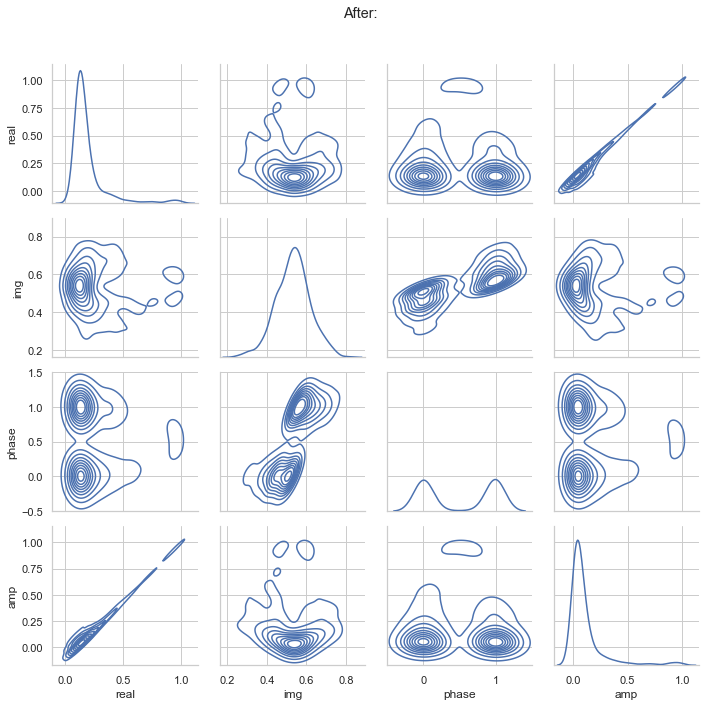

In [9]:
# plotting the relation between the 1st 3 features after transformation

# storing the column names because the transformed data is a numpy array and does not contain column name. But the  \
# iloc function needs a dataframe and so we are converting the numpy array to dataframe which needs the column name.
column_names=list(x_train.columns)

# one way of doing it
g=sns.PairGrid(pd.DataFrame(x_train_transformed, columns=column_names).iloc[:,:5].sample(600))   

# another way of doing the above without converting into dataframe. Note: .sample(600) is returning a random 600 examples not the first 600 examples
#g=sns.PairGrid(pd.DataFrame(x_train_transformed[:600,:3]))
plt.subplots_adjust(top=0.9)
g.fig.suptitle('After:')
g.map_diag(sns.kdeplot)
g.map_offdiag(sns.kdeplot)

In [10]:
#shape of training and testing data

print(x_train_transformed.shape)
print(x_validate_transformed.shape)

(280000, 4)
(70000, 4)


In [11]:
#developing model

input_dim = x_train_transformed.shape[1]


#encoder
input_layer=Input(shape=(input_dim,), name="input")
hidden_layer1=Dense(input_dim, activation='elu', name="hidden1")(input_layer)
hidden_layer2=Dense(3, activation='elu', name="hidden2")(hidden_layer1)

#code

code_layer1=Dense(2, activation='elu', name='code_layer1')(hidden_layer2)

#decoder

hidden_layer3=Dense(3, activation='elu', name="hidden3")(code_layer1)
hidden_layer4=Dense(input_dim, activation='elu', name="hidden4")(hidden_layer3)
output_layer=Dense(input_dim, activation='elu', name="output")(hidden_layer4)

auto_encoder = Model(input_layer,output_layer)
auto_encoder.compile(optimizer='adam', loss='mse', metrics=['acc'])
auto_encoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 4)                 0         
_________________________________________________________________
hidden1 (Dense)              (None, 4)                 20        
_________________________________________________________________
hidden2 (Dense)              (None, 3)                 15        
_________________________________________________________________
code_layer1 (Dense)          (None, 2)                 8         
_________________________________________________________________
hidden3 (Dense)              (None, 3)                 9         
_________________________________________________________________
hidden4 (Dense)              (None, 4)                 16        
_________________________________________________________________
output (Dense)               (None, 4)                 20  

In [12]:
# training the model

Epochs=15

start_time=time.time()

history = auto_encoder.fit(x_train_transformed,x_train_transformed, epochs = Epochs, batch_size=256, shuffle=True,
                       validation_data=(x_validate_transformed,x_validate_transformed))

end_time=time.time()

Train on 280000 samples, validate on 70000 samples
Epoch 1/15
280000/280000 [==============================] - 5s 17us/step - loss: 0.0255 - acc: 0.9214 - val_loss: 0.0128 - val_acc: 0.9432
Epoch 2/15
280000/280000 [==============================] - 4s 13us/step - loss: 0.0038 - acc: 0.9710 - val_loss: 0.0016 - val_acc: 0.9753
Epoch 3/15
280000/280000 [==============================] - 3s 12us/step - loss: 0.0011 - acc: 0.9810 - val_loss: 0.0014 - val_acc: 0.9779
Epoch 4/15
280000/280000 [==============================] - 3s 12us/step - loss: 0.0010 - acc: 0.9854 - val_loss: 0.0013 - val_acc: 0.9832
Epoch 5/15
280000/280000 [==============================] - 3s 12us/step - loss: 8.9090e-04 - acc: 0.9884 - val_loss: 0.0011 - val_acc: 0.9879
Epoch 6/15
280000/280000 [==============================] - 3s 11us/step - loss: 6.3820e-04 - acc: 0.9916 - val_loss: 8.5674e-04 - val_acc: 0.9905
Epoch 7/15
280000/280000 [==============================] - 3s 12us/step - loss: 5.5696e-04 - acc: 0.99

In [13]:
print("GPU time for training:",end_time-start_time,"s")

GPU time for training: 54.26429724693298 s


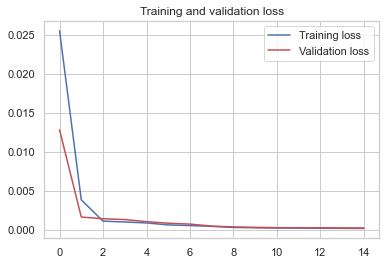

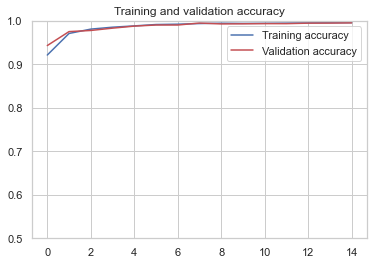

In [14]:
# plotting train and validation loss

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(Epochs)

plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

# plotting train and validation accuracy

acc = history.history['acc']
val_acc = history.history['val_acc']
epochs = range(Epochs)
plt.figure()
axes=plt.gca()
axes.set_ylim([0.5,1])
plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')

plt.title('Training and validation accuracy')
plt.legend()
plt.show()

In [15]:
# Reconstructing data

x_test_transformed=pipeline.transform(x_test)

reconstructions = auto_encoder.predict(x_test_transformed)

mse = np.mean(np.power((reconstructions-x_test_transformed),2),axis=1)

In [16]:
# calculating the modified z-score to find outliers

# manually setting threshold
Threshold= 0.008


def _z_score(mse):
    median_val_mse = np.median(mse)
    diff = np.abs(mse - median_val_mse)
    median_of_diff = np.median(diff)
    
    return 0.6745 * diff/median_of_diff


z_score = _z_score(mse)

outliers= mse > Threshold

print("There are {} outliers in a total of {} signals.".format(np.sum(outliers), len(z_score)))

There are 51888 outliers in a total of 125173 signals.


<function matplotlib.pyplot.show(close=None, block=None)>

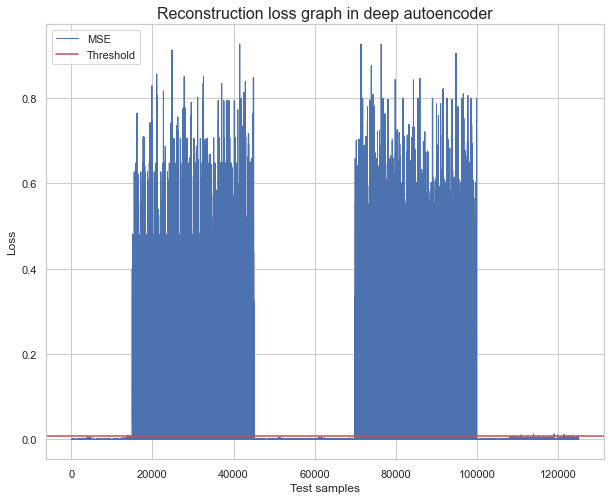

In [17]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(mse, label='MSE', color='b', linewidth=1)
plt.axhline(Threshold, label='Threshold', color='r', linestyle='-')
plt.legend(loc='upper left')
ax.set_title('Reconstruction loss graph in deep autoencoder', fontsize=16)
plt.xlabel('Test samples')
plt.ylabel('Loss')
plt.savefig('dense_autoencoder_singleMCS_multiprotocol.png')
plt.show

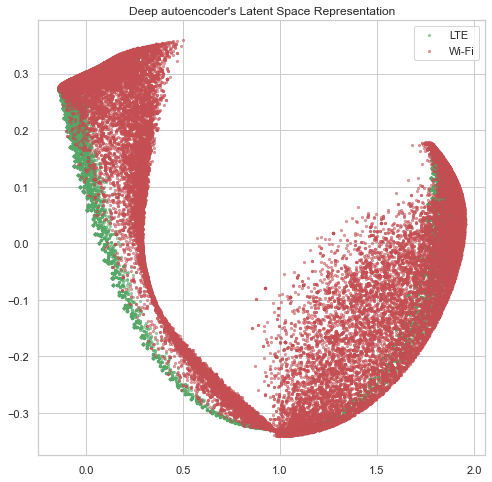

In [18]:
# Visualizing the latent space

encoder = Model(input_layer,code_layer1)

latent_space = encoder.predict(x_test_transformed)

X = latent_space[:,0]
Y = latent_space[:,1]

plt.subplots(figsize=(8,8))
plt.scatter(X[labels==0],Y[labels==0], s=5, c='g', alpha=0.5, label='LTE')
plt.scatter(X[labels==1],Y[labels==1], s=5, c='r', alpha=0.5, label='Wi-Fi')

plt.legend()
plt.title('Deep autoencoder\'s Latent Space Representation')

plt.savefig('Dense autoencoder\'s Latent Space Representation_singleMCS_multiprotocol.png')
plt.show()

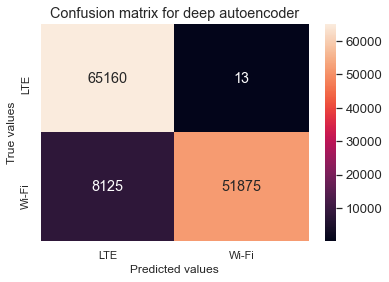

In [20]:
# CONFUSION MATRIX

cm=confusion_matrix(labels,outliers)


ax=plt.subplot()
sns.set(font_scale=1.2)
sns.heatmap(cm,annot=True, fmt='g')

ax.set_xlabel('Predicted values')
ax.set_ylabel('True values')

ax.set_yticklabels(['LTE','Wi-Fi'])
ax.set_xticklabels(['LTE','Wi-Fi'])
ax.set_title('Confusion matrix for deep autoencoder')

plt.savefig('conf_matrix_dense_autoencoder_singleMCS_multiprotocol.png')

In [21]:
# Precision, Recall and F1-score

print("Precision of classification:", "%.2f" % (precision_score(labels,outliers)*100),"%")
print("Recall of classification:","%.2f" % (recall_score(labels,outliers)*100),"%")
print("F1-score of classification:","%.2f" % (f1_score(labels,outliers)))

Precision of classification: 99.97 %
Recall of classification: 86.46 %
F1-score of classification: 0.93


# Observations:

# 1) 'elu' activation function is the best for this task

# 2) providing magnitude, phase features along with I/Q data for input performs better compared to current methods